[<-- retour à l'index](../index.ipynb)

# Variabilité interannuelle aux échelles annuelle, saisonnières et mensuelles de la température pour la réanalyse ERA5
Auteur: Martin Leduc  
Date: Dévembre 2024  

**Description**  
Variabilité interannuelle de la température calculée à partir de la réanalyse ERA5 pour la période 1991-2020 sur l'est de l'Amérique du Nord. La variabilité est définie comme l'écart type interannuel calculé à partir des moyennes annuelle, saisonnières ou mensuelles.

La variabilité du climat récent ainsi quantifiée comporte d'abord une composante due à des mécanismes naturels, comme la variabilité interne ou celle due à des forçages externes comme les émissions volcaniques ou les variations dans l'activité solaire. Cependant, cette quantification de la variabilité comporte aussi une composante due aux forçages anthropiques (émissions de GES). Celle-ci est souvent assez faible en comparaison avec la variabilité naturelle, mais pour les régions nordiques, des modes lents de variabilité naturelle (p.ex. l'Oscillation nord-atlantique) peuvent se superposer aux tendances et rendre complexe la séparation des composantes naturelle et anthropique.

Diverses techniques existent pour retirer la tendances de changement climatique afin d'isoler la variabilité interne, soit par l'application d'un ajustement statistique linéaire ou polynomial, ou encore en utilisant des grands ensembles perturbés aux conditions initiales. Ces approchent sortent du cadre de la présente analyse.

**Références**
- [L'Oscillation nord-atlantique](https://www.ncei.noaa.gov/access/monitoring/nao)
- Utilisation d'un ajustement polynomial pour isoler la variabilité interne: 
  - Hawkins, E., & Sutton, R. (2009). The potential to narrow uncertainty in regional climate predictions. Bulletin of the American Meteorological Society, 90(8), 1095–1107. http://dx.doi.org/10.1175/2009bams2607.1


© Copyright Ouranos Inc. and Martin Leduc 2024  
This work is licensed under [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Imports
import warnings
import numba

warnings.simplefilter("ignore", category=numba.core.errors.NumbaDeprecationWarning)

import xarray as xr
import xclim
from clisops.core import subset
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

In [2]:
# Charger les données
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_ERA5_NAM.ncml"
ds = xr.open_dataset(url, chunks={"time": -1, "lat": 50, "lon": 50})
display(ds)

<xarray.Dataset> Size: 116GB
Dimensions:  (lat: 320, lon: 680, time: 26571)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.25 10.5 10.75 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float32 3kB -179.9 -179.6 -179.4 ... -10.65 -10.4 -10.15
  * time     (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-09-30
Data variables:
    tas      (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    pr       (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
    prsn     (time, lat, lon) float32 23GB dask.array<chunksize=(26571, 50, 50), meta=np.ndarray>
Attributes: (12/28)
    Conventions:          CF-1.9
    cell_methods:         time: mean (interval: 1 day)
    doi:                  https://doi.org/10.24381/cds.adbb2d47
    domain:               NAM
    frequency:            day
    history:              [2022-12-22 05:12:03.164107] Converted variables an...
    ...                   ...
    institute_id:         ECMWF
    dataset_id:           ERA5
    abstract:             ERA5 provides hourly estimates of a large number of...
    dataset_description:  https://www.ecmwf.int/en/forecasts/datasets/reanaly...
    attribution:          Contains modified Copernicus Climate Change Service...
    citation:             Copernicus Climate Change Service (C3S) (2017): ERA...

In [3]:
# Sélectionner la période
debut,fin="1991-01-01", "2020-12-31"
tas_period = ds.tas.sel(time=slice(debut,fin))

# Sélectionner la région: est de l'Amérique du Nord
lon_bnds = [-100, -50]
lat_bnds = [25, 70]

tas_region = subset.subset_bbox(tas_period, lon_bnds=lon_bnds, lat_bnds=lat_bnds)
display(tas_region)

<xarray.DataArray 'tas' (time: 10958, lat: 181, lon: 200)> Size: 2GB
dask.array<getitem, shape=(10958, 181, 200), dtype=float32, chunksize=(10958, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 724B 25.0 25.25 25.5 25.75 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 800B -99.9 -99.65 -99.4 ... -50.65 -50.4 -50.15
  * time     (time) datetime64[ns] 88kB 1991-01-01 1991-01-02 ... 2020-12-31
Attributes:
    long_name:          2 metre temperature
    original_variable:  t2m
    standard_name:      air_temperature
    units:              K
    cell_methods:       time: point
    _ChunkSizes:        [365  50  50]

## Variabilité interannuelle de la moyenne annuelle

In [4]:
# Calculer l'écart-type des moyennes annuelles
std_ann = tas_region.resample(time='YE').mean().std(dim='time',ddof=1)

with Client() as c:
    display(c)    
    std_ann.load()
std_ann

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Workers: 10
Total threads: 80,Total memory: 754.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38509,Workers: 10
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Total threads: 80
Started: Just now,Total memory: 754.31 GiB
Comm: tcp://127.0.0.1:38657,Total threads: 8
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/46839/status,Memory: 75.43 GiB
Nanny: tcp://127.0.0.1:42997,


<xarray.DataArray 'tas' (lat: 181, lon: 200)> Size: 145kB
array([[0.4703785 , 0.5585025 , 0.63307106, ..., 0.21203831, 0.21127164,
        0.21047334],
       [0.50360507, 0.6176202 , 0.67163575, ..., 0.21195646, 0.2118597 ,
        0.21124443],
       [0.5843507 , 0.6578221 , 0.6587535 , ..., 0.21123348, 0.21222444,
        0.21275496],
       ...,
       [0.96447587, 0.9738116 , 0.97869354, ..., 1.4912868 , 1.4692324 ,
        1.43493   ],
       [0.9579893 , 0.96670073, 0.9712301 , ..., 1.452417  , 1.4555194 ,
        1.436102  ],
       [0.9418739 , 0.95038   , 0.9567448 , ..., 1.4206285 , 1.4186745 ,
        1.4006044 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 724B 25.0 25.25 25.5 25.75 ... 69.25 69.5 69.75 70.0
  * lon      (lon) float32 800B -99.9 -99.65 -99.4 ... -50.65 -50.4 -50.15

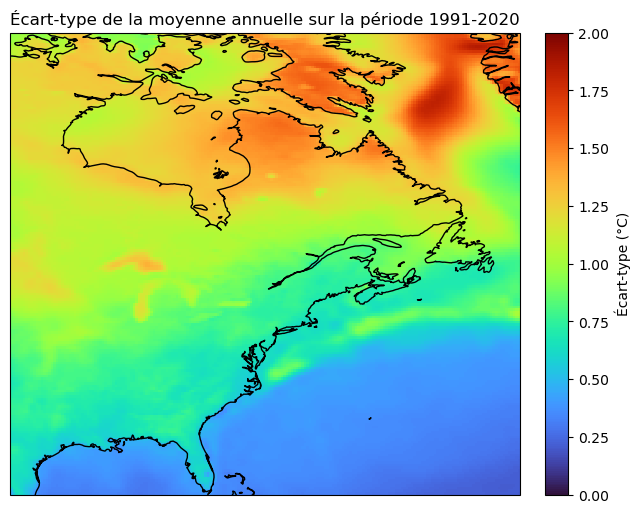

In [5]:
# Afficher carte de l'écart type inter-annuel

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})

# Afficher la variable
p = ax.pcolormesh(std_ann['lon'], std_ann['lat'], std_ann, cmap='turbo',vmin=0,vmax=2)

# Ajouter les lignes de côtes
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.colorbar(p,orientation="vertical", label="Écart-type (°C)", fraction=0.046, pad=0.04)

# Titre
y1=str(tas_region.time.dt.year.values[0])
y2=str(tas_region.time.dt.year.values[-1])
ax.title.set_text('Écart-type de la moyenne annuelle sur la période '+y1+'-'+y2)
#plt.tight_layout()


## Variabilité interannuelle des moyennes saisonnières

In [6]:
# Calculer l'écrat-type des moyennes saisonnières
std_saison=tas_region.groupby(["time.season","time.year"]).mean().std(dim='year',ddof=1)

with Client() as c:
    display(c)      
    std_saison.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Workers: 10
Total threads: 80,Total memory: 754.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35797,Workers: 10
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Total threads: 80
Started: Just now,Total memory: 754.31 GiB
Comm: tcp://127.0.0.1:36535,Total threads: 8
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/39523/status,Memory: 75.43 GiB
Nanny: tcp://127.0.0.1:38393,


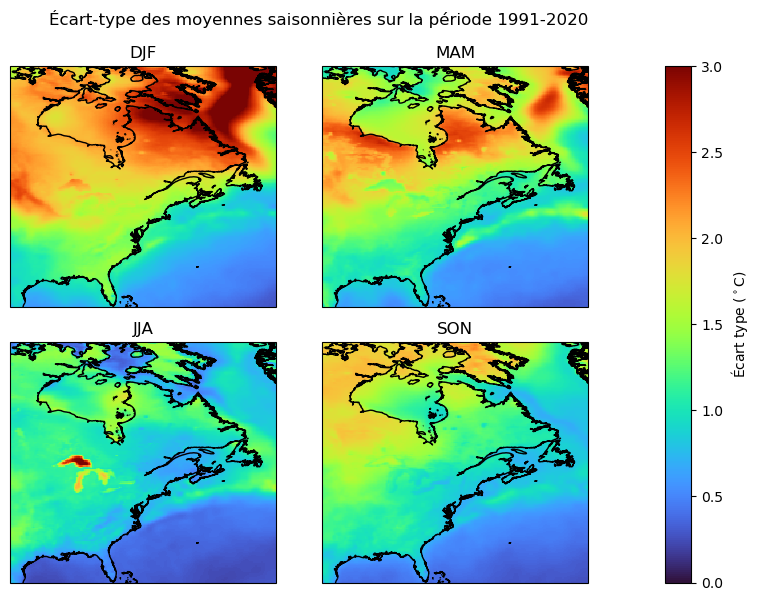

In [7]:
# Afficher les cartes saisonnières

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig,axes = plt.subplots(2,2,figsize=(8, 6), subplot_kw={'projection': projection})
axes = axes.ravel()               

seas=['DJF','MAM','JJA','SON']
for jj,sea in enumerate(seas):
    # Afficher la variable
    p=axes[jj].pcolormesh(std_saison['lon'], std_saison['lat'], std_saison.sel(season=sea), cmap='turbo',vmin=0,vmax=3)

    # Ajouter les lignes de côtes
    axes[jj].coastlines(resolution='10m', color='black', linewidth=1)
    axes[jj].title.set_text(sea)

plt.suptitle('Écart-type des moyennes saisonnières sur la période '+y1+'-'+y2)
plt.tight_layout()

# Ajouter une barre de couleur globale
fig.colorbar(p, ax=axes, orientation='vertical', fraction=0.05, pad=0.1, label='Écart type ($^\circ$C)')


## Variabilité interannuelle des moyennes mensuelles

In [8]:
# Calcul des moyennes mensuelles

# Calculer l'écrat-type des moyennes saisonnières
std_mois=tas_region.groupby(["time.month","time.year"]).mean().std(dim='year',ddof=1)

with Client() as c:
    display(c)
    std_mois.load()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Workers: 10
Total threads: 80,Total memory: 754.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44197,Workers: 10
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/8787/status,Total threads: 80
Started: Just now,Total memory: 754.31 GiB
Comm: tcp://127.0.0.1:46577,Total threads: 8
Dashboard: https://pavics.ouranos.ca/jupyter/user/leduc/proxy/35849/status,Memory: 75.43 GiB
Nanny: tcp://127.0.0.1:33369,


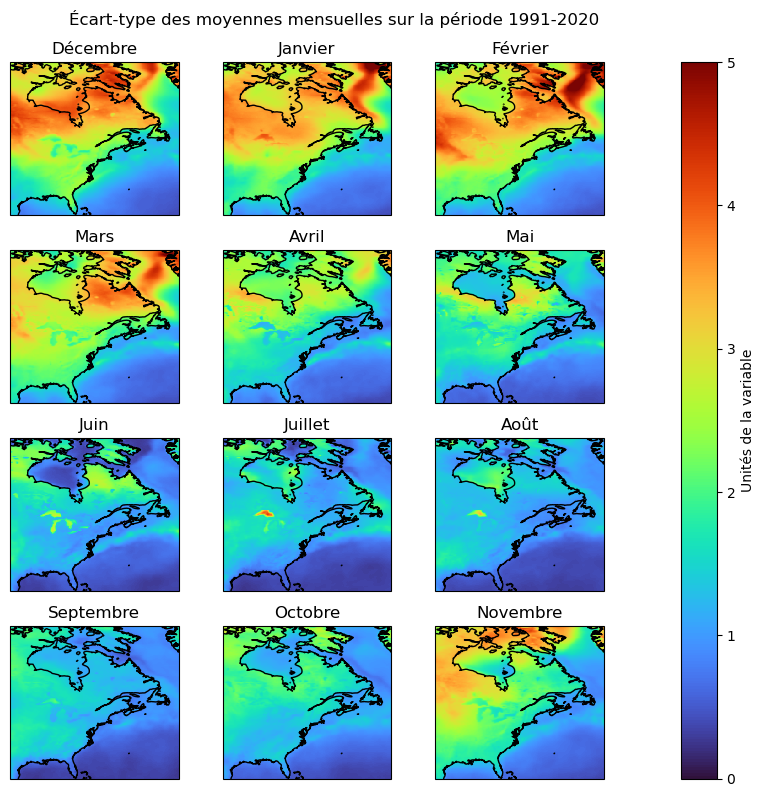

In [21]:
# Afficher les cartes mensuelles

# Créer une projection cartographique
projection = ccrs.PlateCarree()

# Initialiser la figure et les axes
fig,axes = plt.subplots(4,3,figsize=(8, 8), subplot_kw={'projection': projection})
axes = axes.ravel()               

months=[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
months_labels=['Décembre','Janvier','Février','Mars','Avril','Mai','Juin','Juillet','Août','Septembre','Octobre','Novembre']
for jj,month in enumerate(months):

    # Afficher la variable
    p=axes[jj].pcolormesh(std_mois['lon'], std_mois['lat'], std_mois.sel(month=month), cmap='turbo',vmin=0,vmax=5)

    # Ajouter les lignes de côtes
    axes[jj].coastlines(resolution='50m', color='black', linewidth=1)
    #plt.colorbar(p,orientation="vertical", label="Temperature ($^\circ$C)", fraction=0.046, pad=0.04)
    
    # Titres panneaux
    axes[jj].title.set_text(months_labels[jj])

plt.suptitle('Écart-type des moyennes mensuelles sur la période '+y1+'-'+y2)
plt.tight_layout()

# Ajouter une barre de couleur globale
fig.colorbar(p, ax=axes, orientation='vertical', fraction=0.05, pad=0.1, label='Unités de la variable')